# Model Prediction Analysis

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from itertools import chain
import scipy as sc
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'

# ML Imports
from sklearn.metrics import cohen_kappa_score, f1_score
import statsmodels.formula.api as smf


# OS imports
from os.path import join as ospj
from os.path import exists as ospe
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import os

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [3]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [4]:
# Loading seizure level metadata
sz_annots = pd.read_pickle(ospj(prodatapath,'optimized_predicted_channels.pkl'))
sz_annots.columns = [col if col != 'Patient' else 'patient' for col in sz_annots.columns]
# sz_annots = sz_annots[sz_annots.Patient.apply(lambda x: x[:3] != 'CHO')]
sz_annots.head()

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels
0,CHOP005,CHOP005,NRG,0.0,9681.31,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0..."
1,CHOP005,CHOP005,NRG,0.0,42236.26,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0..."
2,CHOP005,CHOP005,NRG,0.0,47123.79,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0..."
3,CHOP005,CHOP005,NRG,0.0,62525.28,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0..."
4,CHOP005,CHOP005,NRG,1.0,68881.53,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0..."


In [5]:
pt_groups = sz_annots.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    electrode_regions = surgical_parcellation(electrode_regions)
    for idx,row in group.iterrows():
        sz_annots.at[idx,'all_rs'] = np.array([r for r in electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique() if r != 'EmptyLabel'])
        for col in ['ueo_chs_strict']:
            chs = row[col]
            # Creating channel mask
            sz_annots.at[idx,col+'_mask'] = np.array([ch in chs for ch in row['all_channels']])
            # Creating region labels and mask
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            sz_annots.at[idx,col.replace('chs','rs')+'_mask'] = np.array([l in electrode_locals for l in np.atleast_1d(sz_annots.loc[idx,'all_rs'])])
            sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        # sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()
sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)


In [6]:
sz_annots.head()

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,all_rs,ueo_chs_strict_mask,ueo_rs_strict_mask,ueo_rs_strict
0,CHOP005,CHOP005,NRG,0.0,9681.31,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte..."
1,CHOP005,CHOP005,NRG,0.0,42236.26,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, False, Tr...","[True, False, False]",left mesial temporal
2,CHOP005,CHOP005,NRG,0.0,47123.79,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[False, False, False, False, False, False, Fal...","[False, True, True]","[right temporal neocortex, right other neocortex]"
3,CHOP005,CHOP005,NRG,0.0,62525.28,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, False, True, True, True, True, True, Tr...","[True, True, True]","[left mesial temporal, right temporal neocorte..."
4,CHOP005,CHOP005,NRG,1.0,68881.53,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte..."


## Annotator Replication

### Seizure -- channel

In [16]:
def calculate_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","patient","spont"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1)
            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_mask2 = group.loc[j,second_annot].reshape(-1)
                annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                annot_dict["spont"].append(not (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

In [17]:
ch_similarity_df = calculate_seizure_similarity(sz_annots,first_annot='ueo_chs_strict_mask',second_annot='ueo_chs_strict_mask',paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


In [18]:
def plot_seizure_similarity(data,agreement='F1',palette=['red','blue','purple'],annot_type=''):
    if agreement == 'kappa':
        data = data[~data.isna().any(axis=1)]
    model = smf.mixedlm(f"{agreement} ~ C(spont)", data, groups="patient")
    result = model.fit()

    # Display the results
    print(result.summary())
    print(result.pvalues)
    plt.figure(figsize=(4.5,5))
    ax = sns.pointplot(data=data,x="spont",y=agreement,errorbar=None,
                markers="_",linestyles="none",palette=palette[:2],
                estimator='median')
    plt.setp(ax.collections, sizes=[1000])
    sns.stripplot(data=data,
                x="spont",
                y=agreement,
                ax=ax,
                alpha=.1,
                palette = palette[:2])
    
    pt_data = data.groupby(["patient","spont"]).median().reset_index()
    pivoted = pt_data.pivot(index='patient', columns='spont', values=agreement).reset_index()
    plt.plot(pivoted.iloc[:,-2:].T,color=palette[2],alpha=.2)
    sns.despine()
    plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
    plt.xlabel('')
    plt.ylabel(f"Seizure Agreement ({agreement})")
    plt.title(f"Seizure-Level Seizure{annot_type} Similarity")

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  F1      
No. Observations:  11510    Method:              REML    
No. Groups:        25       Scale:               0.0562  
Min. group size:   3        Log-Likelihood:      189.3167
Max. group size:   9591     Converged:           Yes     
Mean group size:   460.4                                 
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.247    0.041 5.944 0.000  0.165  0.328
C(spont)[T.True] 0.126    0.013 9.409 0.000  0.100  0.153
patient Var      0.037    0.048                          

Intercept           2.773306e-09
C(spont)[T.True]    5.020639e-21
patient Var         9.737726e-04
dtype: float64


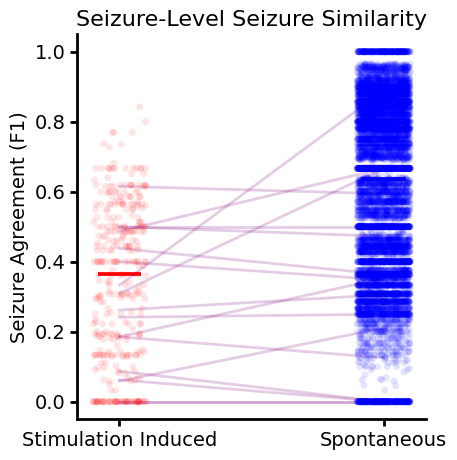

In [19]:
plot_seizure_similarity(ch_similarity_df,agreement='F1')

In [20]:
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'strict'
example_pt = 'HUP249'
group = sz_annots[sz_annots.patient == example_pt]
group.sort_values(ascending=False,by='stim',inplace=True)
kappa_mat = np.zeros((len(group),len(group))); kappa_mat[:] = np.nan
group.reset_index(drop=True,inplace=True)
for i in range(len(group)):
    ch_mask = group.loc[i,f'{annot_type}_chs_{con_type}_mask']
    if group.loc[i,'stim'] == 1:
        print(f"{i} is stim")
    for j in range(i+1,len(group)):
        ch_mask2 = group.loc[j,f'{annot_type}_chs_{con_type}_mask']
        kappa_mat[i,j] = cohen_kappa_score(ch_mask,ch_mask2)

0 is stim


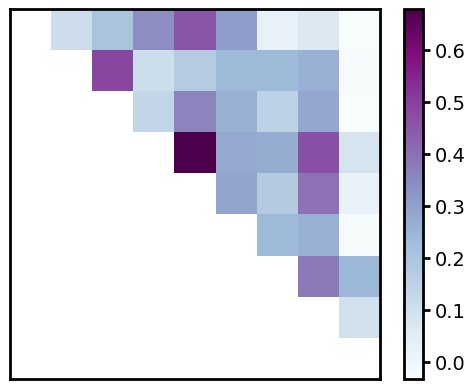

In [21]:
plt.imshow(kappa_mat,cmap = 'BuPu')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,f'ueo_heatmap_pt-{example_pt}.pdf'),bbox_inches='tight')

### Seizure -- region

In [22]:
sz_annots.head()

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,all_rs,ueo_chs_strict_mask,ueo_rs_strict_mask,ueo_rs_strict
0,CHOP005,CHOP005,NRG,0.0,9681.31,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte..."
1,CHOP005,CHOP005,NRG,0.0,42236.26,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, False, Tr...","[True, False, False]",left mesial temporal
2,CHOP005,CHOP005,NRG,0.0,47123.79,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[False, False, False, False, False, False, Fal...","[False, True, True]","[right temporal neocortex, right other neocortex]"
3,CHOP005,CHOP005,NRG,0.0,62525.28,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, False, True, True, True, True, True, Tr...","[True, True, True]","[left mesial temporal, right temporal neocorte..."
4,CHOP005,CHOP005,NRG,1.0,68881.53,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte..."


In [23]:
r_similarity_df = calculate_seizure_similarity(sz_annots,first_annot='ueo_rs_strict_mask',second_annot='ueo_rs_strict_mask')

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  F1       
No. Observations:   11510    Method:              REML     
No. Groups:         25       Scale:               0.0287   
Min. group size:    3        Log-Likelihood:      4045.9213
Max. group size:    9591     Converged:           Yes      
Mean group size:    460.4                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.607    0.059 10.318 0.000  0.492  0.723
C(spont)[T.True] -0.054    0.010 -5.580 0.000 -0.072 -0.035
patient Var       0.084    0.145                           

Intercept           5.817419e-25
C(spont)[T.True]    2.407100e-08
patient Var         6.607211e-04
dtype: float64


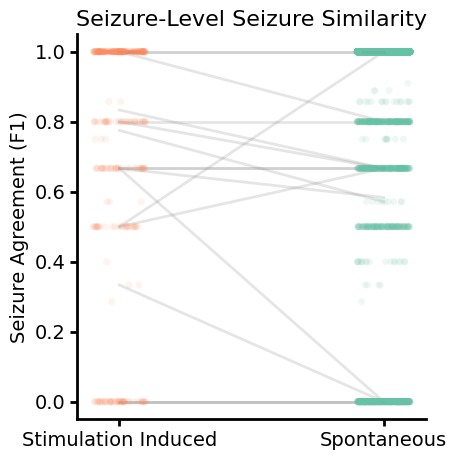

In [24]:
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']
plot_seizure_similarity(r_similarity_df,agreement='F1',palette=pal)

## SOSM
Seizure Onset and Spread Metric

In [ ]:
def SOSM(chs,times,all_chs,max_time):
    '''
    for each channel in all channels, check to see if it's in both lists
    if it's in one list, then make it 
    '''

In [94]:
def calculate_SOSM(annots,ch_annot,time_annot,paired=True):
    annot_list = ["SOSM","patient","spont"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_list = group.loc[i,ch_annot].reshape(-1)
            time_list = group.loc[i,time_annot].reshape(-1)
            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_list2 = group.loc[j,ch_annot].reshape(-1)
                time_list2 = group.loc[j,time_annot].reshape(-1)
                annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                annot_dict["spont"].append(not (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,all_rs,ueo_chs_strict_mask,ueo_rs_strict_mask,ueo_rs_strict,sz_locs,sz_loc_times
0,CHOP005,CHOP005,NRG,0.0,9681.3100,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
1,CHOP005,CHOP005,NRG,0.0,42236.2600,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, False, Tr...","[True, False, False]",left mesial temporal,"[EmptyLabel, left mesial temporal, right other...","[0.0, 0.5, 6.0, 2.0]"
2,CHOP005,CHOP005,NRG,0.0,47123.7900,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[False, False, False, False, False, False, Fal...","[False, True, True]","[right temporal neocortex, right other neocortex]","[EmptyLabel, left mesial temporal, right other...","[0.0, 19.5, 0.0, 0.0]"
3,CHOP005,CHOP005,NRG,0.0,62525.2800,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, False, True, True, True, True, True, Tr...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
4,CHOP005,CHOP005,NRG,1.0,68881.5300,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,HUP273,HUP273b_phaseII,NRG,1.0,20467.7148,20503.00,0.75,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LA01, 

In [ ]:
def SOSM()

## Seizure spread timing

Goal is to create a lineplot with error bar that has the percent of the stim seizure onset zone channels recruited on the y axis and the time since onset on the x axis.
For each stim seizure I need to create that signal. Really i'll have a signal for each stim-spont pair
If I have the time varying % seizing signal for each stim-spont pair I can calculate average across time for a stim seizure
Need to change each 
For each stim seizure:
    extract stim seizure onset zones
    For each spontaneous seizure in the same patient:
        Save time when each of the stim seizure onset regions started seizing in spontaneous seizure

In [25]:
# pt_groups = sz_annots.groupby('Patient')
# for pt,group in pt_groups:
#     region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
#     if not ospe(region_path):
#         continue
#     electrode_regions = pd.read_pickle(region_path)
#     for idx,row in group.iterrows():
#         for col in ['ueo_chs_strict']:
#             chs = row[col]
#             electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
#             sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
#         sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()
# sz_annots.dropna(axis=0,subset='ueo_rs_strict',inplace=True)
# sz_annots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)

In [26]:
sz_annots.head()

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,all_rs,ueo_chs_strict_mask,ueo_rs_strict_mask,ueo_rs_strict
0,CHOP005,CHOP005,NRG,0.0,9681.31,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte..."
1,CHOP005,CHOP005,NRG,0.0,42236.26,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, False, Tr...","[True, False, False]",left mesial temporal
2,CHOP005,CHOP005,NRG,0.0,47123.79,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[False, False, False, False, False, False, Fal...","[False, True, True]","[right temporal neocortex, right other neocortex]"
3,CHOP005,CHOP005,NRG,0.0,62525.28,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, False, True, True, True, True, True, Tr...","[True, True, True]","[left mesial temporal, right temporal neocorte..."
4,CHOP005,CHOP005,NRG,1.0,68881.53,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte..."


In [27]:
# Converting the sz_chs into sz_rs
def ch2r(row,electrode_regions):
    sz_chs = row.sz_chs
    sz_times = row.sz_times
    electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(sz_chs)]['label']])
    sz_locs = []
    sz_loc_times = []
    for loc in np.unique(electrode_locals):
        loc_inds = loc == electrode_locals
        loc_times = sz_times[loc_inds]
        sz_loc_times.append(min(loc_times))
        sz_locs.append(loc)
    row.sz_locs = np.array(sz_locs)
    row.sz_loc_times = np.array(sz_loc_times)
    return row
        
sz_annots[["sz_locs","sz_loc_times"]] = pd.NA
for pt,group in sz_annots.groupby("patient"):
    region_path = get_rpath(prodatapath,pt)
    electrode_regions = pd.read_pickle(region_path)
    electrode_regions = surgical_parcellation(electrode_regions)
    group = group.apply(lambda x: ch2r(x,electrode_regions),axis=1)
    sz_annots.loc[group.index,["sz_locs","sz_loc_times"]] = group.loc[:,["sz_locs","sz_loc_times"]]

In [28]:
time_points =  np.arange(0,60.5,.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [29]:
sz_annots.head()

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,all_rs,ueo_chs_strict_mask,ueo_rs_strict_mask,ueo_rs_strict,sz_locs,sz_loc_times
0,CHOP005,CHOP005,NRG,0.0,9681.31,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
1,CHOP005,CHOP005,NRG,0.0,42236.26,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, False, Tr...","[True, False, False]",left mesial temporal,"[EmptyLabel, left mesial temporal, right other...","[0.0, 0.5, 6.0, 2.0]"
2,CHOP005,CHOP005,NRG,0.0,47123.79,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[False, False, False, False, False, False, Fal...","[False, True, True]","[right temporal neocortex, right other neocortex]","[EmptyLabel, left mesial temporal, right other...","[0.0, 19.5, 0.0, 0.0]"
3,CHOP005,CHOP005,NRG,0.0,62525.28,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, False, True, True, True, True, True, Tr...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
4,CHOP005,CHOP005,NRG,1.0,68881.53,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"


In [30]:
# Now need to iterate through patinets, then iterate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        all_fraction_ts.append(np.mean(fraction_ts,axis=0))
stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL

stim_spread_df['patient'] = all_pts
stim_spread_df_long = stim_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')


In [31]:
stim_spread_df

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,56.0,56.5,57.0,57.5,58.0,58.5,59.0,59.5,60.0,patient
0,0.743590,0.794872,0.820513,0.820513,0.846154,0.846154,0.846154,0.846154,0.846154,0.846154,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,CHOP005
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,CHOP024
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,CHOP024
3,0.916667,0.916667,0.916667,0.916667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,CHOP026
4,0.708333,0.708333,0.708333,0.708333,0.750000,0.750000,0.791667,0.791667,0.791667,0.791667,...,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,CHOP026
5,0.527778,0.527778,0.527778,0.527778,0.583333,0.611111,0.694444,0.750000,0.750000,0.750000,...,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,CHOP026
6,0.416667,0.416667,0.437500,0.437500,0.479167,0.520833,0.583333,0.645833,0.645833,0.645833,...,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,CHOP026
7,0.416667,0.416667,0.437500,0.437500,0.479167,0.520833,0.583333,0.645833,0.645833,0.645833,...,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,CHOP026
8,0.500000,0.583333,0.583333,0.583333,0.666667,0.666667,0.666667,0.666667,0.750000,0.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,CHOP028
9,0.500000,0.583333,0.583333,0.583333,0.666667,0.666667,0.666667,0.666667,0.750000,0.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,CHOP028


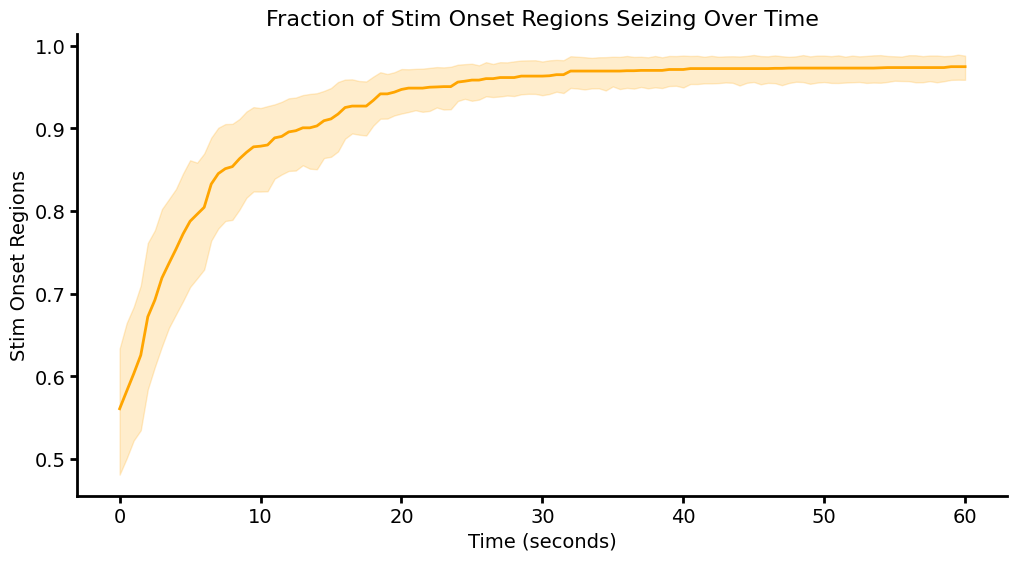

In [32]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim Onset Regions')
sns.despine()
# plt.ylim((0,1))

### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [33]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_rs = np.array([r for r in np.atleast_1d(st_sz.all_rs) if r != 'EmptyLabel'])
                null_locs = sample_rs[np.random.randint(0,len(sample_rs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_locs
                times = sp_sz.sz_loc_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            null_fraction_ts.append(np.mean(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)
# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['patient'] = all_pts
null_spread_df_long = null_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [34]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

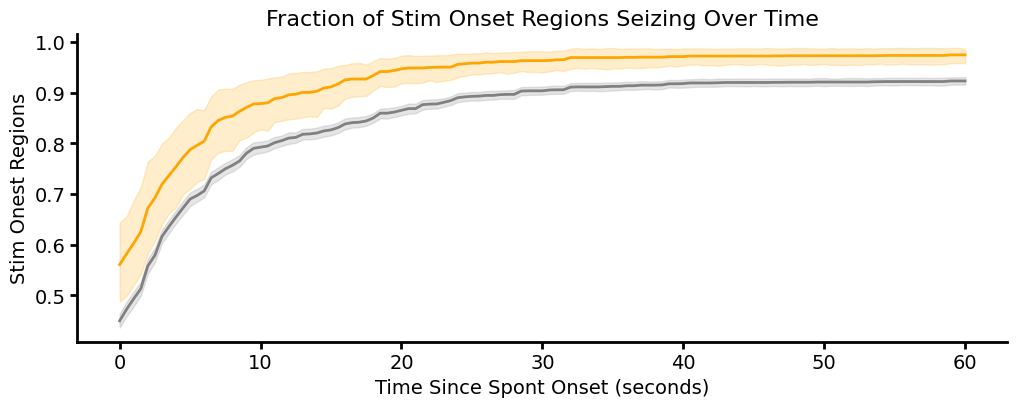

In [35]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Stim Onest Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
plt.savefig(ospj(figpath,'stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

### Calculating recruitment speed

In [36]:
null_speed_df = null_spread_df.iloc[:,:-1].diff(axis=1)
null_speed_df['patient'] = null_spread_df.patient
null_speed_df_long = null_speed_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

stim_speed_df = stim_spread_df.iloc[:,:-1].diff(axis=1)
stim_speed_df['patient'] =stim_spread_df.patient
stim_speed_df_long = stim_speed_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [37]:
is_sig = np.zeros((int(20/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,20.5,0.5)):
    stim_dist = stim_speed_df_long[stim_speed_df_long.Time == t]['Fraction']
    null_dist = null_speed_df_long[null_speed_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

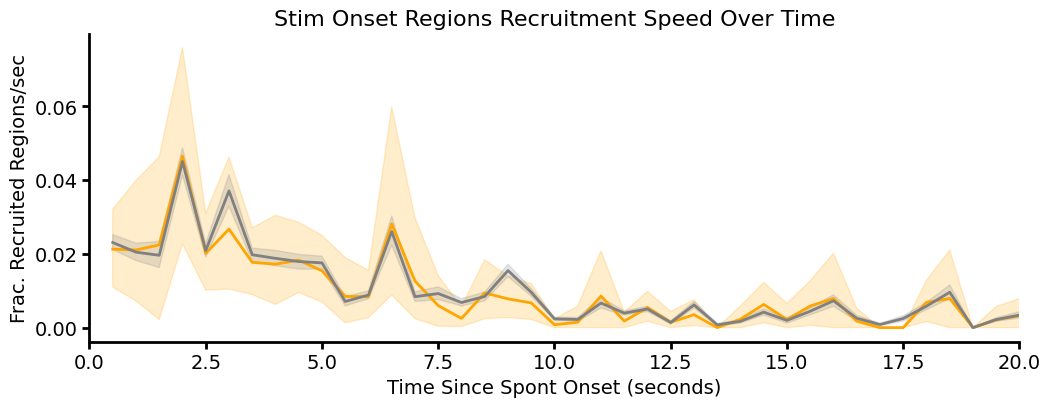

In [38]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_speed_df_long, x='Time', y='Fraction',color='orange',ax=ax)
sns.lineplot(data=null_speed_df_long, x='Time', y='Fraction',color='grey',ax=ax)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Stim Onset Regions Recruitment Speed Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Frac. Recruited Regions/sec')
sns.despine(ax=ax)
plt.xlim((0,20))

# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(0.035, time_points[i], time_points[i + 1], color='k', linewidth=2)
        else:
            ax.hlines(0.035, time_points[i], time_points[i], color='k', linewidth=2)

# plt.savefig(ospj(figpath,'stim_ueo_region_recruitment_speed.pdf'),bbox_inches='tight')

### Calculating fraction of onset regions at 5 seconds comparing null model to stim seizure onset to every other spontaneous seizure onset

In [39]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    spont_szs = group[group.stim == 0]
    print(pt)
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_rs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        spont_fraction_ts.append(np.nanmean(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
spont_spread_df['patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

CHOP005
CHOP024
CHOP026
CHOP028
CHOP035
CHOP037
CHOP041
CHOP044
CHOP045
CHOP049
HUP224
HUP225
HUP229
HUP230
HUP235
HUP238
HUP246
HUP247
HUP249
HUP250
HUP253
HUP257
HUP261
HUP263
HUP266
HUP267
HUP273


In [40]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

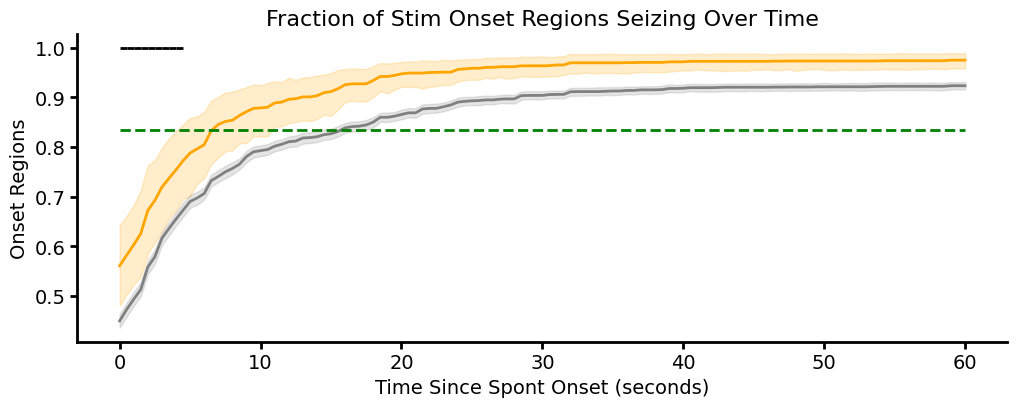

In [41]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2,err_style='band')
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Onset Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
        else:
            ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

## Predicting Stim Seizure Similarity

In [42]:
sz_annots.head()

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,all_rs,ueo_chs_strict_mask,ueo_rs_strict_mask,ueo_rs_strict,sz_locs,sz_loc_times
0,CHOP005,CHOP005,NRG,0.0,9681.31,9755.01,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LH01, LH02, LI01, LI02, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA03, LA04, LD05, LD06, LF01, LF02, LF03, LG0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
1,CHOP005,CHOP005,NRG,0.0,42236.26,42315.93,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK09, LI09]","[LI09, LI10, LK02, LK03, LK04, LK05, LK06, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LF07, LF08, LF09, LI08, LI09, LI10, LK02, LK0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.5, 0.0, 5.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, False, Tr...","[True, False, False]",left mesial temporal,"[EmptyLabel, left mesial temporal, right other...","[0.0, 0.5, 6.0, 2.0]"
2,CHOP005,CHOP005,NRG,0.0,47123.79,47210.90,0.75,"[LK09, LK12, LK13, LI09, LC11, LC12, LC13, LC1...","[LA06, LA07, LC11, LC12, LC13, LC14, LC15, LC1...","[LK07, LK09, LK12, LK13, LI09, LC10, LC11, LC1...","[LC10, LC11, LC12, LC13, LC14, LC15, LC16, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[20.0, 34.0, 21.0, 20.5, 19.5, 5.0, 7.5, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[False, False, False, False, False, False, Fal...","[False, True, True]","[right temporal neocortex, right other neocortex]","[EmptyLabel, left mesial temporal, right other...","[0.0, 19.5, 0.0, 0.0]"
3,CHOP005,CHOP005,NRG,0.0,62525.28,62616.22,0.75,"[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...","[LD08, LD09, LD10, LE01, LE02, LE03, LE07, LE0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LE01, LE02, LE03, LE07, LE08, LI04, LI05, LI0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, False, True, True, True, True, True, Tr...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"
4,CHOP005,CHOP005,NRG,1.0,68881.53,68944.57,0.75,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LD06, LD07, LD08, LD09, LF01, LF0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LB01, LB02, LC01, LC02, LD06, LD0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[left mesial temporal, right temporal neocorte...","[True, True, True, True, True, True, True, Tru...","[True, True, True]","[left mesial temporal, right temporal neocorte...","[EmptyLabel, left mesial temporal, right other...","[0.0, 0.0, 0.0, 0.0]"


### Calculating seizure level metadata

Make a dataframe with the following columns: Patient, stim seizure, spontaneous seizure, stim onset regions, spontaneous onset regions, kappa, stim seizure duration, hippocampal localization? 

273 is atypical

In [43]:
def model_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","patient","IEEGname","approximate_onset","stim_sz_length","stim_sz_spread"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot]
            if group.loc[i,'stim'] == 1:
                for j in range(len(group)):
                    if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                        continue
                    ch_mask2 = group.loc[j,second_annot]
                    annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                    annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                    annot_dict["patient"].append(pt)
                    annot_dict["IEEGname"].append(group.loc[i,'iEEG_ID'])
                    annot_dict["approximate_onset"].append(group.loc[i,'approximate_onset'])
                    annot_dict["stim_sz_length"].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
                    annot_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
                    
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

In [44]:
# model_dict = {key:[] for key in ['patient','onset','agreement','stim_sz_length','stim_sz_spread']}
# annot_type = 'ueo'
# con_type = 'strict'

# for pt,group in sz_annots.groupby('patient'):
#     group.sort_values(ascending=False,by='stim',inplace=True)
#     group.reset_index(drop=True,inplace=True)
#     for i in range(len(group)):
#         for j in range(i+1,len(group)):
#             if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
#                 continue
#             if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
#                 all_rs = group.loc[i,'all_rs']
#                 chs = group.loc[i,f'{annot_type}_rs_{con_type}']
#                 ch_mask = np.array([l in chs for l in group.loc[i,'all_rs']])
#                 chs2 = group.loc[j,f'{annot_type}_rs_{con_type}']
#                 ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_rs']])
#                 model_dict['patient'].append(pt)
#                 model_dict['onset'].append(group.loc[i,'approximate_onset'])
#                 model_dict['agreement'].append(cohen_kappa_score(ch_mask,ch_mask2))
#                 model_dict['stim_sz_length'].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
#                 model_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
# model_df = pd.DataFrame(model_dict)

In [45]:
model_df = model_seizure_similarity(sz_annots,first_annot='ueo_chs_strict_mask',second_annot='ueo_chs_strict_mask',paired = False)
model_df = model_df.sort_values('approximate_onset')

Skipped [] due to insufficient spontaneous seizures


In [46]:
model_df.head()

,kappa,F1,patient,IEEGname,approximate_onset,stim_sz_length,stim_sz_spread
169,-0.013708,0.072727,HUP229,HUP229_phaseII,1109.40,67.51,0.781609
115,0.301370,0.504348,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984
114,0.456483,0.581395,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984
113,0.233526,0.315789,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984
112,0.193744,0.338028,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984


In [47]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)
seizures_df.columns = [col if col != 'Patient' else 'patient' for col in seizures_df.columns]
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
# drop HF stim induced seizures
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)
seizures_df.head()

,patient,IEEGname,EEC,UEO,Other_onset_description,approximate_onset,end,source,stim,stim_channels,EEC onset channels,UEO onset channels,Notes,to_annotate,typical,LVFA,Summaries
391,CHOP026,CHOP026,NaN,NaN,NaN,771.89,797.89,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,HUP229,HUP229_phaseII,NaN,NaN,NaN,1109.40,1176.91,annotations,1.0,LG1-LG2,NaN,NaN,time not clearly marked,1.0,1.0,0.0,NaN
359,CHOP010,CHOPCCEP_010,NaN,NaN,NaN,2230.26,2267.78,NaN,1.0,RK2-RK3,NaN,NaN,Not concordant with Caren's sheet,1.0,NaN,NaN,NaN
411,CHOP035,CHOPCCEP_035,NaN,NaN,NaN,2872.35,2899.06,NaN,1.0,LN3-LN4,NaN,NaN,NaN,1.0,1.0,NaN,NaN
386,CHOP026,CHOPCCEP_026,NaN,NaN,NaN,3608.77,3742.56,NaN,1.0,LH9-LH10,NaN,NaN,Possible earlier onset,NaN,NaN,NaN,NaN


In [52]:
model_df_wtypical = pd.merge_asof(model_df,
                                    seizures_df[['approximate_onset','patient',"IEEGname","to_annotate","typical"]],
                                    on='approximate_onset',by=['patient','IEEGname'],
                                    tolerance = 240,
                                    direction='nearest')

In [53]:
model_df_wtypical.head()

,kappa,F1,patient,IEEGname,approximate_onset,stim_sz_length,stim_sz_spread,to_annotate,typical
0,-0.013708,0.072727,HUP229,HUP229_phaseII,1109.40,67.51,0.781609,1.0,1.0
1,0.301370,0.504348,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984,1.0,1.0
2,0.456483,0.581395,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984,1.0,1.0
3,0.233526,0.315789,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984,1.0,1.0
4,0.193744,0.338028,CHOP035,CHOPCCEP_035,2872.35,26.71,0.368984,1.0,1.0


In [66]:
# Join the two tables and make linear model!
lm_df = pd.merge(model_df_wtypical,patient_table[['ptID','mtle','laterality','focality']],left_on='patient',right_on='ptID',how='left').drop('ptID',axis=1)

In [89]:
lm_df_grouped = lm_df.groupby('approximate_onset')
lm_df_left = lm_df_grouped[[l for l in lm_df.columns if l != 'F1']].max()
lm_df_left['F1'] = lm_df_grouped['F1'].apply(lambda x: np.nanpercentile(x,50))
lm_df_left.reset_index(drop=True,inplace=True)

In [90]:
lm_df_left.dropna(axis=0,subset=['mtle','laterality','focality'],how='any',inplace=True)
lm_df_left.head()

,kappa,patient,IEEGname,approximate_onset,stim_sz_length,stim_sz_spread,to_annotate,typical,mtle,laterality,focality,F1
0,-0.013708,HUP229,HUP229_phaseII,1109.40000,67.51000,0.781609,1.0,1.0,1.0,0.0,0.0,0.072727
3,0.814371,HUP230,HUP230_phaseII,3860.24000,18.16000,0.241935,1.0,1.0,1.0,0.0,0.0,0.615385
9,0.586474,HUP257,HUP257_CCEP,8576.79000,67.34000,0.561798,1.0,1.0,1.0,1.0,0.0,0.400000
12,0.696035,HUP238,HUP238_phaseII,10652.96973,139.37027,0.913043,1.0,1.0,1.0,0.0,0.0,0.185185
14,0.549618,HUP266,HUP266_phaseII,12508.67000,44.67000,0.644068,1.0,0.0,0.0,1.0,1.0,0.253846


In [91]:
lm_df_left['focality'] = lm_df_left['focality'] == 0

In [92]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

# Load data
dat = lm_df_left

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('F1 ~ stim_sz_length + stim_sz_spread + typical + mtle + focality', data=dat).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                 -0.129
Method:                 Least Squares   F-statistic:                    0.5648
Date:                Tue, 30 Jul 2024   Prob (F-statistic):              0.726
Time:                        13:40:53   Log-Likelihood:                 7.3906
No. Observations:                  20   AIC:                            -2.781
Df Residuals:                      14   BIC:                             3.193
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2991      0.140  

In [93]:
sc.stats.ttest_ind(lm_df_left.loc[lm_df_left.typical == 0,'F1'],lm_df_left.loc[lm_df_left.typical == 1,'F1'])

TtestResult(statistic=-1.3279997074678618, pvalue=0.20077309957959086, df=18.0)